In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

### The dataset used in the training is Flower102

In [2]:
data = torchvision.datasets.CIFAR10(root=".", download=True)

IMG_SIZE = 64
img_transforms = [#transforms.Resize((IMG_SIZE, IMG_SIZE)), 
                  transforms.RandomHorizontalFlip(), 
                  transforms.ToTensor(), # data scaled to 0 to 1
                  transforms.Lambda(lambda t: t*2-1)] # data scaled to -1 to 1
data_transform = transforms.Compose(img_transforms)

training_data = torchvision.datasets.CIFAR10(root=".", train=True, download=True, transform=data_transform)
# val_data = torchvision.datasets.CIFAR10(root=".", split="val", download=True, transform=data_transform)
test_data = torchvision.datasets.CIFAR10(root=".", train=False, download=True, transform=data_transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
len(training_data), len(test_data)

(50000, 10000)

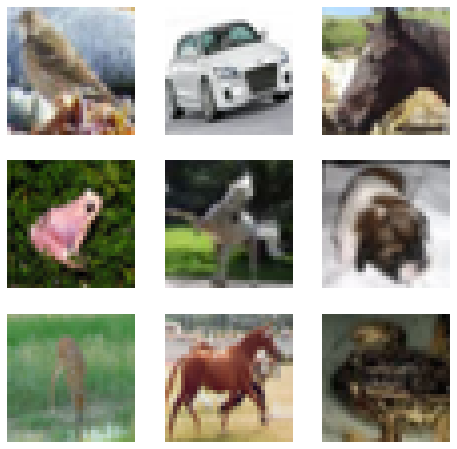

In [4]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data), size=(1,)).item()
    img, label = data[sample_idx]
    figure.add_subplot(rows, cols, i)
    # plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

In [5]:
K = 10


## Forward Process

In [6]:
model_name = "vgg"
num_classes = K
feature_extract = True
use_pretrained = True

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

model_ft = models.vgg11_bn(pretrained=use_pretrained)
set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.classifier[6].in_features
# customized layer, 6 is vgg11_bn
model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
input_size = 224


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [8]:
epochs = 20
lr = 0.001
bs = 100
min_valid_loss = np.inf
loss_func = torch.nn.CrossEntropyLoss()

train_dataloader = DataLoader(training_data, batch_size=bs, shuffle=True)
# eval_dataloader = DataLoader(val_data, batch_size=bs, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=bs, shuffle=True)
eval_dataloader = test_dataloader

def train_loop(epoch, min_valid_loss, loss_func, optimizer, model, eval=False):
    train_loss = 0.0
    trainf1 = 0.0
    model.train()
    
    for i, data in tqdm(enumerate(train_dataloader)):
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        target = model(inputs)
        preds = torch.argmax(target, dim=1)
        f1score = f1_score(labels.detach().numpy(), preds.detach().numpy(), average='weighted')
        labels = nn.functional.one_hot(labels, K)
        loss = loss_func(target.float(), labels.float())
        #loss = loss_func(target, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        trainf1 += np.sum(f1score)


    if eval==True:
        valid_loss = 0.0
        valf1 = 0.0
        model.eval()     # Optional when not using model Specific layer
        for i, data in enumerate(eval_dataloader):
            inputs, labels = data
            if torch.cuda.is_available():
                inputs, labels =inputs.cuda(), labels.cuda()
            target = model(inputs)
            preds = torch.argmax(target, dim=1)
            f1score = f1_score(labels.detach().numpy(), preds.detach().numpy(), average='weighted')
            labels = nn.functional.one_hot(labels, K)
            loss = loss_func(target.float(), labels.float())
            valid_loss += loss.item() * len(inputs)
            valf1 += np.sum(f1score)
            if i == 20: break

        if epoch%1==0:
            print(f'Epoch {epoch+1} \t Training Loss: {train_loss, train_loss / len(train_dataloader)} \t Training F1 Score: {trainf1, trainf1 / len(train_dataloader)}')
            print(f'\t Validation Loss: {valid_loss, valid_loss / bs / 21}  \t Validation F1 Score: {valf1, valf1 / 21}')
        if min_valid_loss > valid_loss:
            print(f"Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f})")
            min_valid_loss = valid_loss
            # Saving State Dict
            torch.save(model.state_dict(), 'saved_model.pth')
    else:
        if epoch%1==0:
            print(f'Epoch {epoch+1} \t Training Loss: {train_loss, train_loss / len(train_dataloader)} \t Training F1 Score: {trainf1, trainf1 / len(train_dataloader)}')
    return min_valid_loss

In [9]:
for epoch in range(epochs):
    min_valid_loss = train_loop(epoch, min_valid_loss, loss_func, optimizer_ft, model_ft)

500it [13:56,  1.67s/it]


Epoch 1 	 Training Loss: (782.4230077266693, 1.5648460154533386) 	 Training F1 Score: (228.65395233058945, 0.4573079046611789)


500it [13:55,  1.67s/it]


Epoch 2 	 Training Loss: (703.6589020490646, 1.4073178040981293) 	 Training F1 Score: (257.4002637802925, 0.514800527560585)


500it [13:59,  1.68s/it]


Epoch 3 	 Training Loss: (684.1015065908432, 1.3682030131816865) 	 Training F1 Score: (264.7802555313176, 0.5295605110626352)


500it [13:47,  1.65s/it]


Epoch 4 	 Training Loss: (678.529239654541, 1.357058479309082) 	 Training F1 Score: (264.5345773353916, 0.5290691546707832)


500it [13:45,  1.65s/it]


Epoch 5 	 Training Loss: (673.1549664735794, 1.3463099329471588) 	 Training F1 Score: (267.6778055287358, 0.5353556110574716)


500it [13:44,  1.65s/it]


Epoch 6 	 Training Loss: (669.1864401698112, 1.3383728803396224) 	 Training F1 Score: (269.0800684990351, 0.5381601369980702)


500it [13:48,  1.66s/it]


Epoch 7 	 Training Loss: (663.9318913221359, 1.3278637826442719) 	 Training F1 Score: (270.2481501280141, 0.5404963002560282)


500it [13:47,  1.65s/it]


Epoch 8 	 Training Loss: (664.9561825990677, 1.3299123651981353) 	 Training F1 Score: (269.77219967115764, 0.5395443993423152)


500it [13:47,  1.65s/it]


Epoch 9 	 Training Loss: (662.0481978058815, 1.324096395611763) 	 Training F1 Score: (269.28231111041606, 0.5385646222208321)


500it [13:50,  1.66s/it]


Epoch 10 	 Training Loss: (662.0459433794022, 1.3240918867588043) 	 Training F1 Score: (271.2669299422361, 0.5425338598844722)


500it [13:44,  1.65s/it]


Epoch 11 	 Training Loss: (661.161475777626, 1.3223229515552521) 	 Training F1 Score: (270.7827717596802, 0.5415655435193604)


500it [13:46,  1.65s/it]


Epoch 12 	 Training Loss: (660.4036489725113, 1.3208072979450225) 	 Training F1 Score: (271.0323162955066, 0.5420646325910131)


500it [13:46,  1.65s/it]


Epoch 13 	 Training Loss: (656.2433341145515, 1.312486668229103) 	 Training F1 Score: (273.5642665300903, 0.5471285330601806)


500it [13:48,  1.66s/it]


Epoch 14 	 Training Loss: (657.3634340763092, 1.3147268681526183) 	 Training F1 Score: (272.34364869846934, 0.5446872973969387)


500it [13:44,  1.65s/it]


Epoch 15 	 Training Loss: (656.9366487264633, 1.3138732974529266) 	 Training F1 Score: (273.39954402071544, 0.5467990880414308)


500it [13:48,  1.66s/it]


Epoch 16 	 Training Loss: (656.559922337532, 1.313119844675064) 	 Training F1 Score: (271.9401373631047, 0.5438802747262095)


500it [13:52,  1.66s/it]


Epoch 17 	 Training Loss: (658.3244680166245, 1.316648936033249) 	 Training F1 Score: (272.4064885856209, 0.5448129771712418)


500it [13:48,  1.66s/it]


Epoch 18 	 Training Loss: (656.6863421201706, 1.3133726842403413) 	 Training F1 Score: (271.57550630041703, 0.5431510126008341)


500it [13:51,  1.66s/it]


Epoch 19 	 Training Loss: (656.1349319815636, 1.3122698639631272) 	 Training F1 Score: (272.3809722647836, 0.5447619445295673)


500it [13:55,  1.67s/it]

Epoch 20 	 Training Loss: (655.7157508730888, 1.3114315017461777) 	 Training F1 Score: (273.8950633055994, 0.5477901266111989)
